# FFT

This notebook converts the signal from a 150_000 datapoint segment from temporal to frequency domain and back.
Processing the signal in terms of frequencies can be useful in terms of denoising it. For instance by removing lower amplitude frequencies.

Visualizing the reconstructued signal after filtering is very useful in terms of experimenting with filters.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
DATADIR='../input'

# Any results you write to the current directory are saved as output.

In [2]:
df = pd.read_csv(os.path.join(DATADIR, 'train.csv'),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [3]:
class FFTFeatures(object):
    SEQUENCE_LENGHT = 150_000
    WINDOW = 4096

    def shape(self):
        return (self.SEQUENCE_LENGHT // self.WINDOW, self.WINDOW // 2, 2)

    def generate(self, df: pd.DataFrame, predict=False):
        """ Convert a signal into frequency space with amplitude and phase
            per frequency.
        """
        steps = self.shape()[0]
        bsize = steps * self.WINDOW
        offset = self.SEQUENCE_LENGHT - bsize
        data = df['acoustic_data'].values[offset:].reshape(steps, -1)
        yf = np.fft.fft(data)
        yf = yf[:, : self.WINDOW // 2]
        yf = yf / self.WINDOW
        epsilon = 1.0e-9
        X = np.stack([np.log(np.abs(yf) + epsilon), np.angle(yf)], axis=2)
        if predict:
            return X
        y = df['time_to_failure'].iloc[df.shape[0] - 1]
        return X, np.array([y])


def fft_invert(X: np.array, datapoints=4096) -> np.array:
    """ Convert a signal from frequency to temporal domain 
    """
    assert X.shape == (2048, 2)
    x = np.linspace(0, 1, datapoints)
    f = np.fft.fftfreq(X.shape[0] * 2, d=1/(X.shape[0] * 2))

    m = np.outer(x, f)
    amp = np.exp(X[:, 0])
    phase = X[:, 1]
    p = np.concatenate([phase, np.array([0]), np.flip(-phase[1:])])
    a = np.concatenate([amp, np.array([0]), np.flip(amp[1:])])
    ys = np.dot(np.cos(2 * np.pi * m + p), a)
    return ys


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_signal_and_recon(df: pd.DataFrame, Xs: np.array):
    start = 0
    end = start + 150_000
    step = 10
    fig, axes = plt.subplots(2, 1, figsize=(40, 16), sharex=True)
    ax1 = axes[0]
    ax1.set_ylim((-100, 100))
    ax1.set_title('Signal')
    ax1.plot(df_sample[start:end:step]['acoustic_data'].values, color='b')
    ax1.set_ylabel('signal', color='b')
    ax2 = ax1.twinx()
    ax2.plot(df_sample[start:end:step]['time_to_failure'].values, color='r')
    ax2.set_ylabel('ttf', color='r')
    ax3 = axes[1]
    ax3.set_ylim((-100, 100))
    ax3.set_title('Reconstructed signal')
    ax3.plot(Xs[start:end:step], color='g')
    plt.show()

def fftseq_to_signal(X: np.array):
    Xs = np.zeros((150_000, 1))
    offset = 150_000 - (FFTFeatures().shape()[0] * 4096)
    for i in range(X.shape[0]):
        Xs[offset:offset+4096] = fft_invert(X[i])[:, np.newaxis]
        offset += 4096
    return Xs

Show an example 150_000 datapoint segment and the reconstructed signal without any filtering.

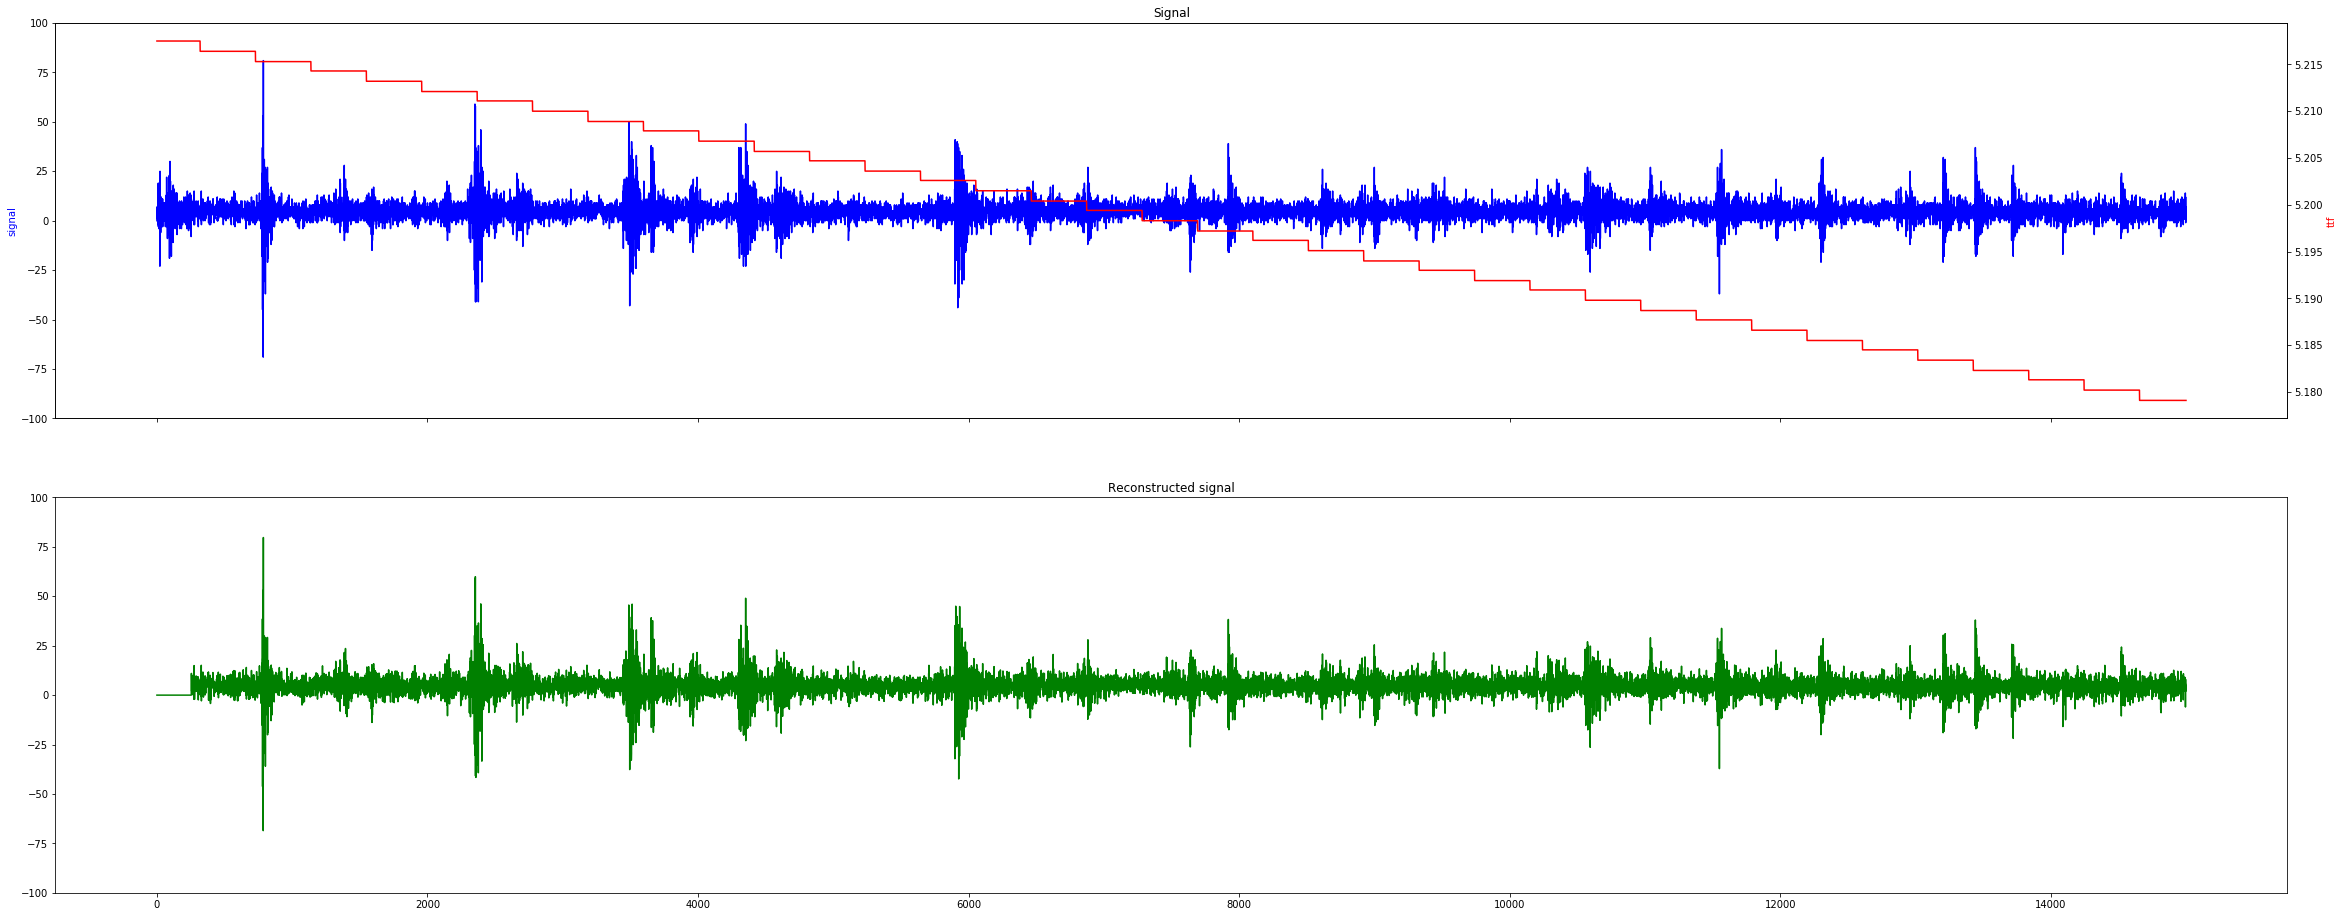

In [5]:
# select an arbitrary signal sample

start = 200 * 150_000
df_sample = df[start:start+150_000]

X = FFTFeatures().generate(df_sample, True)
Xs = fftseq_to_signal(X)
show_signal_and_recon(df_sample, Xs)

Create an animation of the amplitudes in the frequency domain.

In [6]:
from matplotlib import animation, rc
from IPython.display import HTML

def show_frequency_amp(X: np.array):
    fig, ax = plt.subplots(figsize=(12, 4))
    rects = ax.bar(np.arange(2048), np.exp(X[0, :, 0]), log=True)
    def init():
        return rects
    def animate(i):
        for j, rect in enumerate(rects):
            rect.set_height(np.exp(X[i, j, 0]))
        return rects
    anim = animation.FuncAnimation(
        fig, animate, init_func=init,
        frames=FFTFeatures().shape()[0], interval=360, blit=True, repeat=False)
    plt.close(anim._fig)
    return anim

anim = show_frequency_amp(X)
HTML(anim.to_jshtml())

Generate a filter eliminates all frequencies bellow mean + sigma. The signal looks the same with sigma = 1.

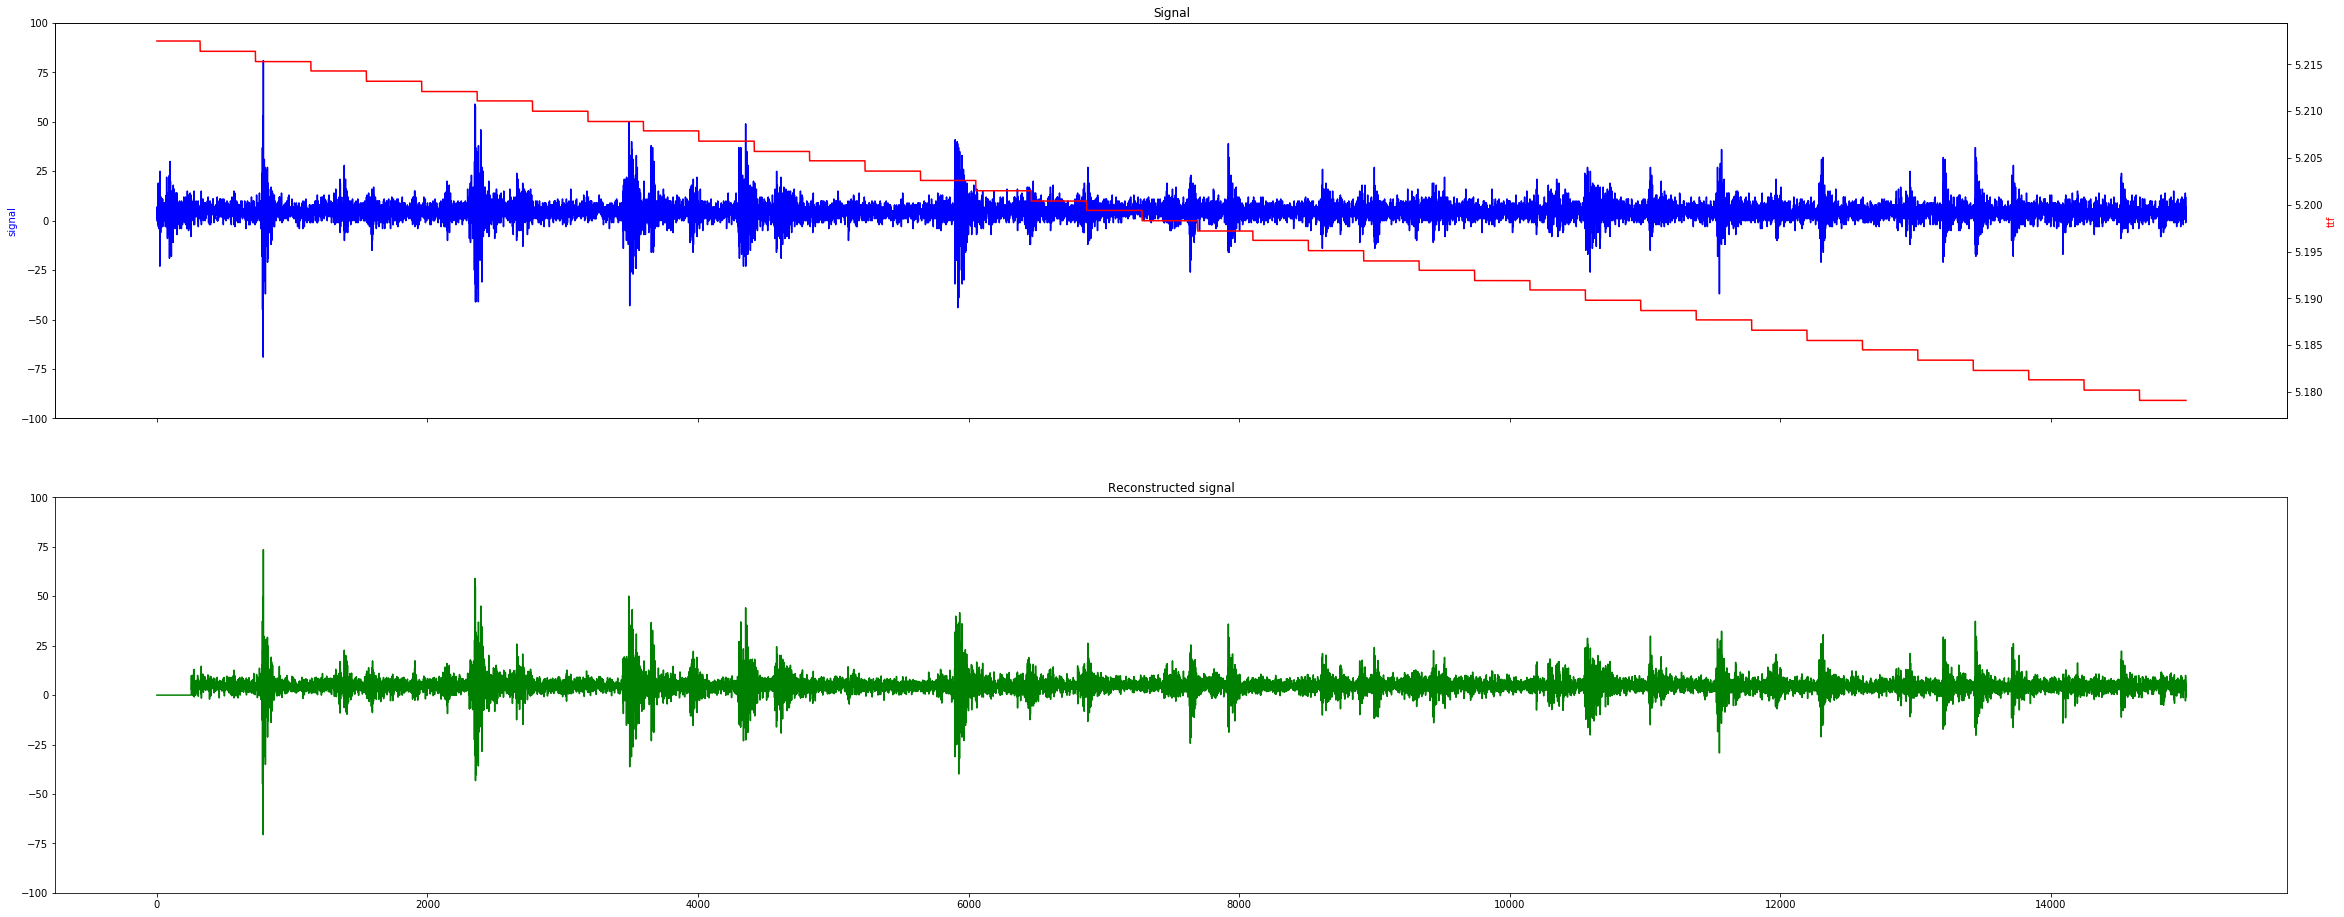

In [7]:
def apply_filter(X, filter_fn):
    Xf = np.empty(X.shape)
    for ts in range(X.shape[0]):
        Xf[ts] = filter_fn(X[ts])
    return Xf

def filter_sigma(X, sigma=1):
    epsilon = 1.0e-9
    m = np.mean(X[:, 0])
    d = np.std(X[:, 0])
    idx = np.where(X[:, 0] < (m + sigma * d))[0]
    Xp = X.copy()
    Xp[idx, 0] = np.log(epsilon)
    return Xp

Xs_f0 = fftseq_to_signal(apply_filter(X, filter_sigma))
show_signal_and_recon(df_sample, Xs_f0)

Calculate frequencies that contribute to the signal amplitide peaks

In [8]:
def peak_frequencies(X: np.array, k_peak = 1, k_freq = 4):
    """ Compute what frequencies contribute the most to the top peaks.
    """
    amp = X[:, 0]
    phase = X[:, 1]
    x = np.linspace(0, 1, 4096)
    f = np.fft.fftfreq(amp.size * 2, d=1/(amp.size * 2))

    m = np.outer(x, f)
    p = np.concatenate([phase, np.array([0]), np.flip(-phase[1:])])
    fs = np.cos(2 * np.pi * m + p)
    
    a = np.exp(amp)
    a = np.concatenate([a, np.array([0]), np.flip(a[1:])])
    # ys is the reconstructuted signal in temporal domain
    ys = np.dot(fs, a)

    # min amplitude
    l_idx = np.argpartition(ys, k_peak)[:k_peak]

    # Ax = b, where A = cos ( [time x frequency] + phase )
    # indices in b correspond to rows in A.
    # indices correspond to a time slot, each time slot is
    # Sum ( cos(f + p) . amp )

    l_val = fs[l_idx]
    l_m = np.einsum('ij,j->ij', l_val, a)
    l_freq = np.argpartition(l_m, k_freq, axis=1)[:, :k_freq]

    # max amplitude
    h_idx = np.argpartition(ys, -k_peak)[-k_peak:]
    h_val = fs[h_idx]
    h_m = np.einsum('ij,j->ij', h_val, a)
    h_freq = np.argpartition(l_m, -k_freq, axis=1)[:, -k_freq:]

    # convert negative frequencies (> 2k) into positives
    cond = l_freq > 2048
    l_freq[cond] = 4096 - l_freq[cond] + 1
    cond = h_freq > 2048
    h_freq[cond] = 4096 - h_freq[cond] + 1    

    freq = set(l_freq.flatten())
    freq |= set(h_freq.flatten())
    return list(freq)


Show only the top frequencies at the peaks. The example bellow selects the top 2 positive and negative peaks for each 4k block and select 16 frequencies from each.

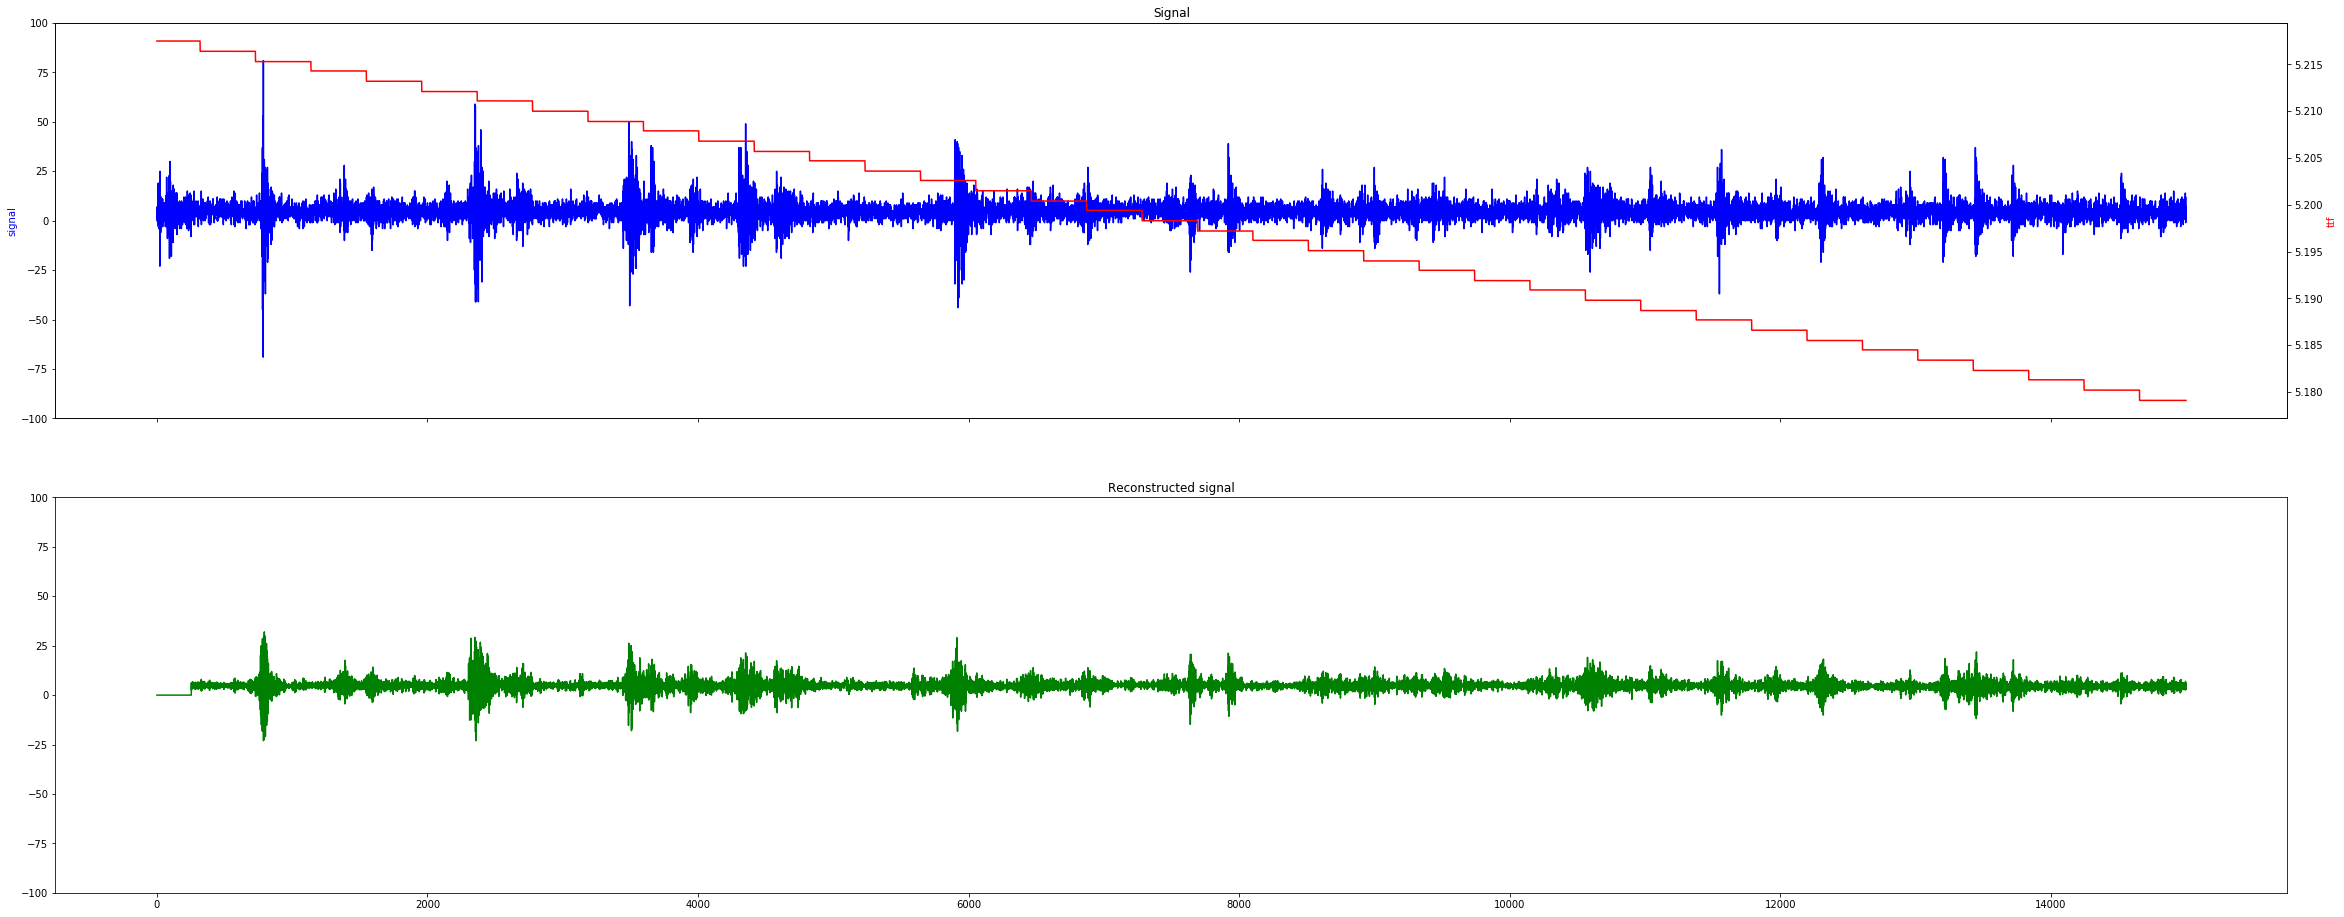

In [9]:
def filter_peek_frequencies(X, k_peak=2, k_freq=16):
    epsilon = 1.0e-9
    Xp = np.zeros(X.shape)
    Xp[:, 0] = np.log(epsilon)
    frequencies = peak_frequencies(X, k_peak, k_freq)
    Xp[frequencies, :] = X[frequencies, :]
    return Xp

Xs_f1 = fftseq_to_signal(apply_filter(X, filter_peek_frequencies))
show_signal_and_recon(df_sample, Xs_f1)

There a small number of frequencies that seem to account for most of the signal peaks, even across a random distribution of samples.

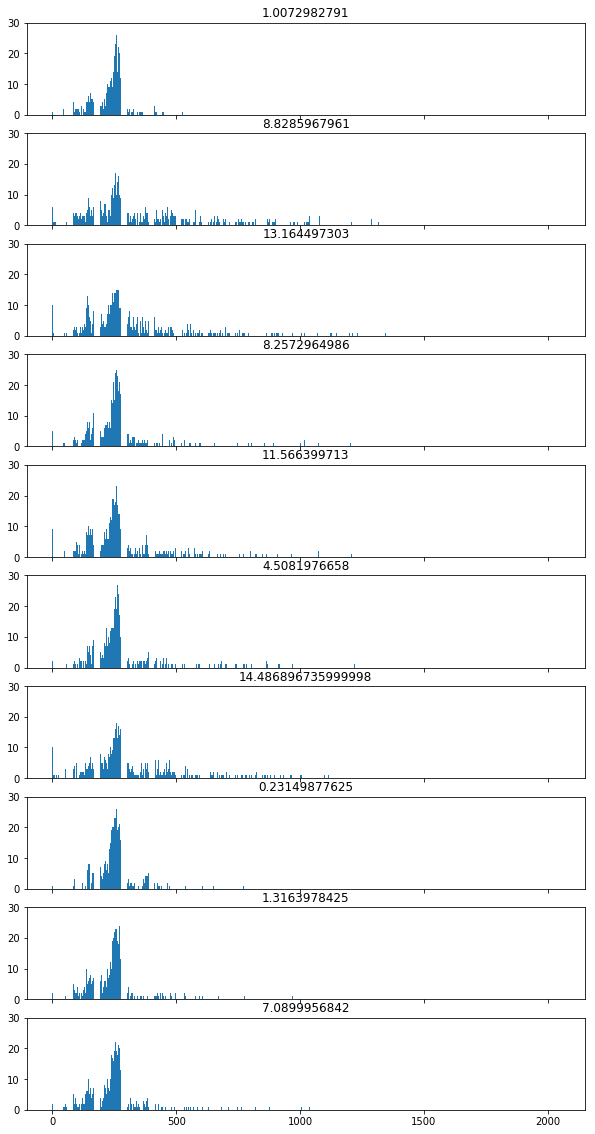

In [11]:
import random

def segment_peak_frequencies(X):
    counts = np.zeros((2048, ))
    for ts in range(X.shape[0]):
        freqs = peak_frequencies(X[ts], 4, 16)
        counts[freqs] += 1
    return counts

# pick n samples
N_SAMPLES = 10
fig, axes = plt.subplots(N_SAMPLES, 1, figsize=(10, 20), sharex=True)
for i, ax in enumerate(axes):
    idx = random.randint(0, df.shape[0] // 150_000)
    df_xsample = df[idx * 150_000: (idx + 1) * 150_000]
    Xi = FFTFeatures().generate(df_xsample, True)
    counts = segment_peak_frequencies(Xi)
    ax.set_title(str(df_xsample['time_to_failure'].iloc[-1]))
    ax.bar(np.arange(2048), counts)
    ax.set_ylim((0, 30))
plt.show()

Zoom in on the top frequencies.

In [ ]:
TOP_FREQUENCIES = [
    slice(140, 150),
    slice(160, 200),
    slice(210, 300),
]

def filter_top_frequencies(X):
    epsilon = 1.0e-9
    Xp = np.zeros(X.shape)
    Xp[:, 0] = np.log(epsilon)
    for r in TOP_FREQUENCIES:
        Xp[r, :] = X[r, :]
    return Xp

Xs_f2 = fftseq_to_signal(apply_filter(X, filter_top_frequencies))
show_signal_and_recon(df_sample, Xs_f2)

In [ ]:
def show_top_frequency(X: np.array):
    size = 0
    for r in TOP_FREQUENCIES:
        size += r.stop - r.start
    Xp = np.empty((X.shape[0], size,))

    offset = 0
    for r in TOP_FREQUENCIES:
        rsize = r.stop - r.start
        Xp[:, offset:offset + rsize] = np.exp(X[:, r, 0])
        offset += rsize

    fig, ax = plt.subplots(figsize=(12, 4))

    xaxis = []
    for r in TOP_FREQUENCIES:
        xaxis.append(np.arange(r.start, r.stop))
    xaxis = np.concatenate(xaxis)

    rects = ax.bar(xaxis, Xp[0], log=True)
    ax.set_ylim((np.min(Xp), np.max(Xp)))

    def init():
        return rects
    def animate(i):
        for j, rect in enumerate(rects):
            rect.set_height(Xp[i, j])
        return rects
    anim = animation.FuncAnimation(
        fig, animate, init_func=init,
        frames=FFTFeatures().shape()[0], interval=360, blit=True, repeat=False)
    plt.close(anim._fig)
    return anim

anim = show_top_frequency(X)
HTML(anim.to_jshtml())